# K-Mean Clustering

In this notebook, we apply **unsupervised machine learning methods** to identify patterns across Berlin’s subdistricts (Ortsteile). 

The goal is to **segment neighborhoods into meaningful profiles** based on affordability, demographics, and amenities.

We begin with **preprocessing** and **dimensionality reduction**, then  **K-Mean clustering**. Finally, we interpret the clusters by linking them back to affordability and neighborhood characteristics.

This analysis provides the foundation for the subdistrict profiles and the recommender system developed in later steps of the project.


# Environment & Data

We prepare the notebook for clustering.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Visualization settings
sns.set(style="whitegrid", context="notebook")

# Data loading
RAW_CSV = "../data/processed/final_master.csv"
df = pd.read_csv(RAW_CSV)

PCA_CSV = "../data/modeling/berlin_pca/berlin_subdistricts_pca.csv"
dfp = pd.read_csv(PCA_CSV)

id_col = "ortsteil"
pc_cols = [c for c in dfp.columns if c.startswith("PC")]

X = dfp[pc_cols].values
ids = dfp[id_col].copy()

In [7]:
# Helper function
def plot_clusters(X, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X["PC1"], y=X["PC2"], hue=labels, palette="tab10", s=60)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Finding optimel number of K

We apply KMeans to partition subdistricts into k clusters. We explore different values of k and use metrics such as the silhouette score and visual inspection to decide on the most interpretable solution.

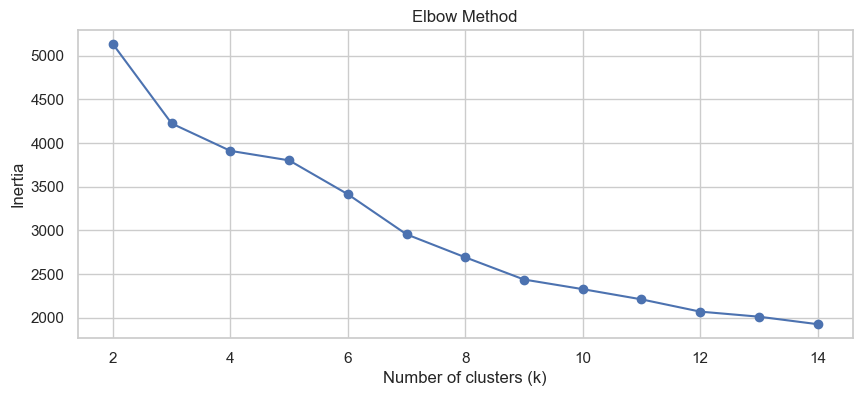

In [2]:
# Run KMeans for a range of cluster numbers
inertia = []
silhouette_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Curve (Inertia)
plt.figure(figsize=(10, 4))
plt.plot(K, inertia, 'o-', label="Inertia")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

📌 **Key Insights**

* The curve shows a sharp drop in inertia from k = 2 → 4, suggesting that these early clusters explain much of the variance in the data.

* After k = 4 or 5, the curve begins to flatten, meaning additional clusters provide less new information and mainly capture smaller variations.

* The clearest elbow point is around k = 4, which balances simplicity and explanatory power.

* This supports selecting 4 clusters for the main KMeans segmentation of Berlin’s subdistricts.


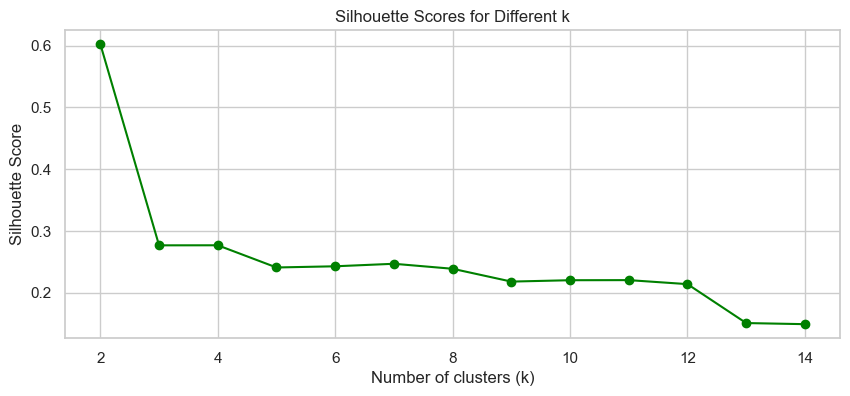

In [3]:
# Plot Silhouette Scores
plt.figure(figsize=(10, 4))
plt.plot(K, silhouette_scores, 'o-', color="green", label="Silhouette Score")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.grid(True)
plt.show()

📌 **Key Insights**

* The highest silhouette score appears at `k = 2` (≈ 0.6), but this solution is too simplistic and doesn’t capture Berlin’s neighborhood diversity.

* Scores for `k = 3` and `k = 4` (~0.27–0.28) are lower but still acceptable for social science datasets with high dimensionality and complex variation.

* Beyond `k = 5`, silhouette scores drop further (~0.2 or below), indicating weaker separation and less meaningful clustering.

* Taken together, the silhouette analysis supports a moderate number of clusters (k = 3–4) rather than very high values.

📌 Choosing the Final Number of Clusters

By combining the Elbow Method and Silhouette Score results, we can make a robust decision on the number of clusters (k) for KMeans:

* The Elbow Method shows a clear bend at `k = 4`, after which the reduction in inertia becomes less significant. This suggests that four clusters capture most of the meaningful structure in the data without unnecessary complexity.

* The Silhouette Score peaks at `k = 2`, but this solution is overly simplistic and fails to reflect Berlin’s neighborhood diversity. Scores for `k = 3–4` (~0.27–0.28) are still reasonable in the context of high-dimensional socioeconomic data, while values drop off further for larger k.

👉 **Taken together, both methods indicate that k = 4 is the most appropriate choice:**

* It balances interpretability and cluster separation.

* It aligns with urban logic by revealing distinct neighborhood types rather than forcing too many small clusters.

# K-Mean Clustering K=4

In [4]:
# Train KMeans with k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4 = kmeans_4.fit_predict(X)

# Create a copy to compare both clusterings
df_clusters = dfp[[id_col]].copy()
df_clusters["k4_cluster"] = labels_4

# Number of subdistricts per cluster
print(df_clusters["k4_cluster"].value_counts().sort_index())

k4_cluster
0    57
1     5
2    32
3     2
Name: count, dtype: int64


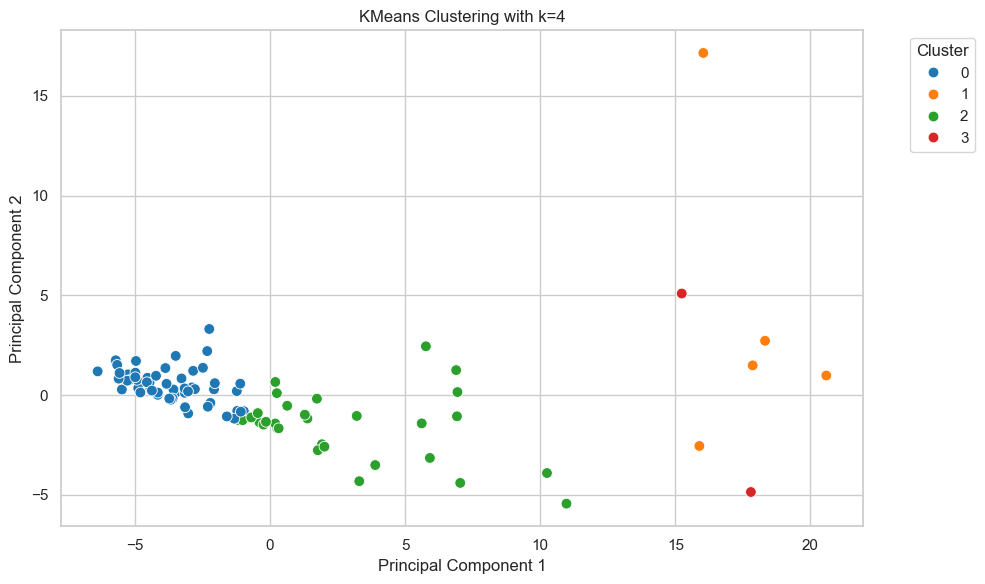

In [ ]:
plot_clusters(dfp[pc_cols], labels_4, "KMeans Clustering with k=4")

📌 **Key Insights**

* The PCA projection reveals clear separation between the clusters, with minimal overlap.

* Cluster 0 (blue): The largest and most densely grouped cluster, representing many subdistricts with balanced or average characteristics.

* Cluster 2 (green): A sizable group, distinct from Cluster 0, capturing neighborhoods with a different socioeconomic and amenity profile.

* Cluster 1 (orange) and Cluster 3 (red): Smaller, more isolated clusters that represent outliers or specialized neighborhood types, such as wealthy prestige areas or dense vibrant hubs.

* The spread of points indicates variance within clusters: while some clusters (like blue) are compact, others (like green) cover a wider range of variation.